In [14]:
from sklearn import datasets
import numpy as np

def test_split(index, value, dataset): #split data
    left, right = list(), list()
    for row in dataset: #value 를 기준으로 left, right로 분할
        if row[index] < value :
            left.append(row)
        else:
            right.append(row)
    return left, right

def gini_index(groups, classes): #gini 계수
    n_instances = float(sum([len(group) for group in groups])) #total element count
    gini = 0.0
    for group in groups: #각 그룹은 기준 대로 나눠짐
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size #각 group에 label별 분포도 계산
            score += p * p # 1 - sum(p(i)^ 2) = sum(i !=j ,p(i)p(j)) 
        gini += (1.0 - score) * (size / n_instances) # 각 그룹 지니계수 가중 평균 
    return gini

def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset)) #get target type
    
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0]) - 1): #data의 각 col 별로 실행
        for row in dataset:
            groups = test_split(index, row[index], dataset) #임시 값을 기준으로 나눠봄
            gini = gini_index(groups, class_values) # 지니 계수 계산
            if gini < b_score : #gini가 더 작을시 update
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    
    return {'index' : b_index, 'value' : b_value, 'groups' : b_groups}

def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth: #일정 깊이의 depth 이상일때 분할 stop
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    if len(left) <= min_size: #분할 후 한 그룹의 갯수가 일정 갯수 미만이면 stop
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left) #re split
        split(node['left'], max_depth, min_size, depth + 1)
    
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth + 1)

def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key = outcomes.count) #제일 많이 차지하는 label return

def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

def print_tree(node, depth = 0):
    if isinstance(node, dict):
        print("%s[X%d < %.3f]" % ((depth * ' ', (node['index'] + 1), node['value'])))
        print_tree(node['left'], depth + 1)
        print_tree(node['right'], depth + 1)
    else:
        print('%s[%s]' % ((depth * '', node)))

iris = datasets.load_iris()
dataset = np.c_[iris.data, iris.target]

tree = build_tree(dataset, 3, 1)
print_tree(tree)

[X3 < 3.000]
 [X1 < 5.100]
  [X1 < 4.900]
[0.0]
[0.0]
  [X1 < 5.100]
[0.0]
[0.0]
 [X4 < 1.800]
  [X3 < 5.000]
[1.0]
[2.0]
  [X3 < 4.900]
[2.0]
[2.0]


      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


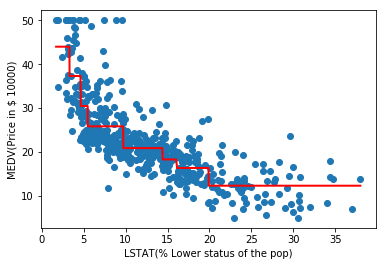

In [21]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('housing.data', header = None, sep = '\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
             'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
print(df.head())

X = df[['LSTAT']].values
y = df[['MEDV']].values

tree = DecisionTreeRegressor(max_depth = 3) #회귀를 위한 결정트리 모델 생성, 최대 깊이 = 3
tree.fit(X, y) # 학습

#draw
sort_idx = X.flatten().argsort()
plt.scatter(X[sort_idx], y[sort_idx])
plt.plot(X[sort_idx], tree.predict(X[sort_idx]), color = 'red', linewidth = 2)
plt.xlabel('LSTAT(% Lower status of the pop)')
plt.ylabel('MEDV(Price in $ 10000)')
plt.show()